In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load the dataset
df = pd.read_csv("synthetic_sp500_300k.csv")

# Use only 'Close' values for modeling
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[['Close']])

# Replace original 'Close' with scaled values
df['Close'] = scaled_values


In [3]:
import numpy as np

def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

# Set sequence length (e.g., 30 time steps per input)
sequence_length = 30
X = create_sequences(df['Close'].values, sequence_length)


In [4]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# Load and normalize
df = pd.read_csv("synthetic_sp500_300k.csv")
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# Create sequences
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

sequence_length = 30
X = create_sequences(df['Close'].values, sequence_length)

# Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# LSTM Autoencoder
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, X_train, epochs=10, batch_size=64, validation_split=0.1, shuffle=False)


Epoch 1/10
3375/3375 [==============================] - 151s 44ms/step - loss: 0.0019 - val_loss: 0.0434
Epoch 2/10
3375/3375 [==============================] - 2022s 599ms/step - loss: 0.0013 - val_loss: 0.0407
Epoch 3/10
3375/3375 [==============================] - 155s 46ms/step - loss: 0.0016 - val_loss: 0.0444
Epoch 4/10
3375/3375 [==============================] - 158s 47ms/step - loss: 0.0015 - val_loss: 0.0446
Epoch 5/10
3375/3375 [==============================] - 158s 47ms/step - loss: 0.0019 - val_loss: 0.0456
Epoch 6/10
3375/3375 [==============================] - 159s 47ms/step - loss: 0.0016 - val_loss: 0.0424
Epoch 7/10
3375/3375 [==============================] - 3824s 1s/step - loss: 0.0016 - val_loss: 0.0432
Epoch 8/10
3375/3375 [==============================] - 6506s 2s/step - loss: 0.0018 - val_loss: 0.0449
Epoch 9/10
3375/3375 [==============================] - 162s 48ms/step - loss: 0.0018 - val_loss: 0.0454
Epoch 10/10
3375/3375 [==============================] 

In [6]:
# Get model predictions on training set
X_train_pred = model.predict(X_train)

# Calculate reconstruction error (MSE per sequence)
train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=(1, 2))

# Define threshold
threshold = np.mean(train_mse) + 2 * np.std(train_mse)


7500/7500 [==============================] - 57s 7ms/step


In [7]:
X_test_pred = model.predict(X_test)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

# Mark anomalies
anomalies = test_mse > threshold


1875/1875 [==============================] - 14s 7ms/step


In [8]:
print(f"Total anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of test data marked as anomalies: {100 * np.mean(anomalies):.2f}%")


Total anomalies detected: 0
Percentage of test data marked as anomalies: 0.00%


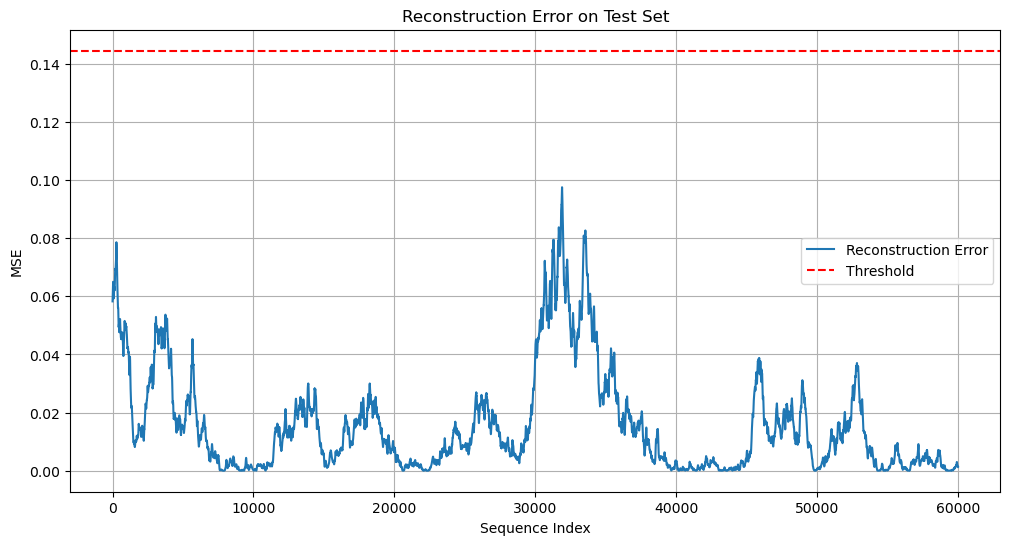

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Test Set")
plt.xlabel("Sequence Index")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Get the original timestamps for test sequences
anomaly_dates = df['Date'].iloc[-len(X_test):].reset_index(drop=True)

# Combine with errors and anomaly flag
results = pd.DataFrame({
    'Date': anomaly_dates,
    'Reconstruction_Error': test_mse,
    'Anomaly': anomalies
})

# Show only anomalies
anomalies_df = results[results['Anomaly']]
print(anomalies_df.head())


Empty DataFrame
Columns: [Date, Reconstruction_Error, Anomaly]
Index: []
